# Washington Landslide Data Preprocessing

## Overview
This notebook processes landslide data from the Washington Geological Survey (WGS) into a standardized format for integration with other regional datasets. We primarily look at the deposits and the landslide compilation layer of the bigger dataset.

The workflow includes:

1. **Data Loading**: Load GeoDataFrame layers from WGS Landslides.gdb geodatabase

2. **Layer Analysis**: Examine deposits and compilation layers structure and content

3. **Data Standardization**: Standardize confidence levels, movement types, and material classifications

4. **Reference Integration**: Create proper citation references for the dataset

5. **Data Combination**: Merge deposits and compilation layers with priority handling

6. **Column Selection**: Select and rename columns to match unified schema

8. **Export**: Save processed data as GeoJSON for further analysis

**Input**: WGS_Landslides.gdb (deposits and landslide_compilation layers) 
 
**Output**: washington_landslides_processed.geojson

Obtain the Washington Geological Survey Landslide data from the official website: https://dnr.wa.gov/washington-geological-survey/geologic-hazards-and-environment/landslides

Create a directory 'Data' in your projects root folder and place the downloaded files inside it.

Also create a directory 'ProcessedDataSets' inside of your PreProcessing Directory

# Initialization

In [1]:
import fiona
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
gdb_dir = "../Data/Washington/ger_portal_landslides_ds29_v1.4_Apr2024/WGS_Landslides.gdb"

layers = fiona.listlayers(gdb_dir)
print("Layers in geodatabase:")
for lyr in layers:
    print("  -", lyr)


Layers in geodatabase:
  - scarp_and_flank
  - rock_fall_deposit
  - rock_fall_scarp
  - recent_landslide_point
  - SLIP_fans
  - landslide_compilation_study_footprints
  - study_areas
  - SLIP_landslide
  - fan
  - landslide_deposit
  - landslide_compilation
  - scarp


# Initial Inspection of Deposits Layer

In [3]:
deposits = gpd.read_file(gdb_dir, layer="landslide_deposit")

In [4]:
# Basic info
print(deposits.shape)      # (n_deposits, n_fields)
print(deposits.dtypes)     # field names and types

(15060, 23)
LANDSLIDE_ID                        int64
MATERIAL                           object
MOVEMENT                           object
MOVE_CODE                          object
CONFIDENCE                         object
RELATIVE_AGE                       object
YEAR_MOVE                          object
FIELD_VERIFIED                     object
SLOPE_DEG                           int64
HS_HEIGHT_FT                      float64
FAIL_DEPTH_FT                     float64
MVMT_AZIMUTH_DEG                  float64
VOLUME_FT3                        float64
AVG_SCARP_DIST_FT                 float64
LS_NAME                            object
COMMENTS                           object
DISPLAY_ON_PORTAL                  object
CHANGE_TYPE                        object
CHANGE_DATE           datetime64[ns, UTC]
CHANGE_DESCRIPTION                 object
Shape_Length                      float64
Shape_Area                        float64
geometry                         geometry
dtype: object


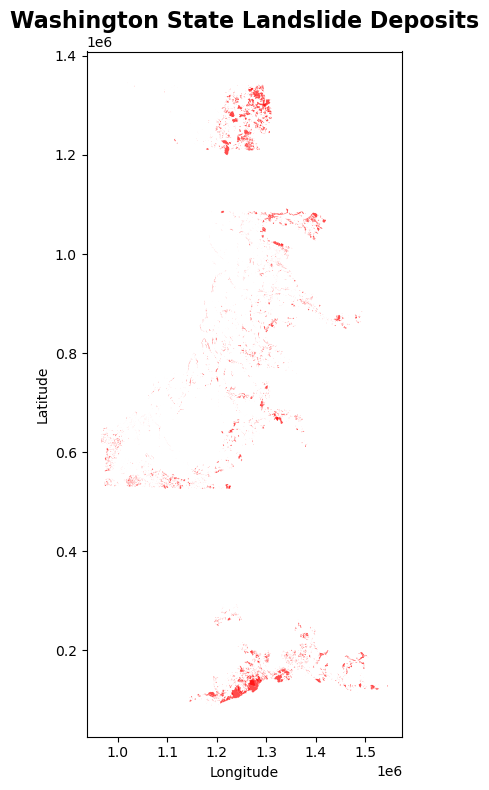

In [6]:
# Simple plot of landslide deposits
fig, ax = plt.subplots(figsize=(12, 8))
deposits.plot(ax=ax, alpha=0.7, color='red', markersize=0.5)
ax.set_title("Washington State Landslide Deposits", fontsize=16, fontweight='bold')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()

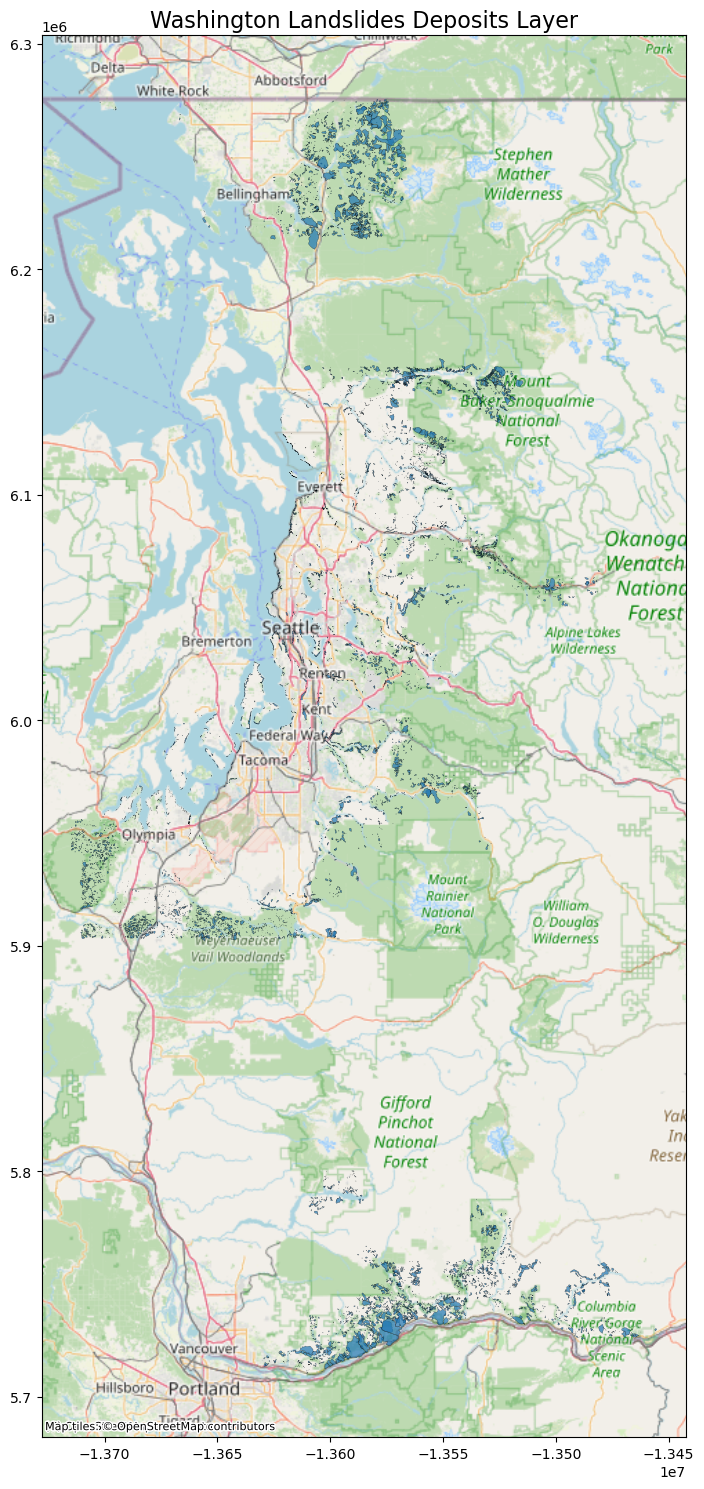

In [7]:
import matplotlib.pyplot as plt
import contextily as ctx

gdf_3857 = deposits.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(15, 15))
gdf_3857.plot(ax=ax, edgecolor="k", linewidth=0.2, alpha=0.7)

# When the axis data is already in EPSG:3857, you can omit the crs argument:
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.title('Washington Landslides Deposits Layer', fontsize=16)
ctx.add_attribution(ax, "Map tiles: © OpenStreetMap contributors")
plt.tight_layout()
plt.show()


# Inspect Landslide Compilation Dataset

In [9]:
# Load landslide compilation layer
compilation = gpd.read_file(gdb_dir, layer="landslide_compilation")

# Inspect the compilation dataframe
print("Landslide compilation shape:", compilation.shape)
print("\nColumn names:")
for col in compilation.columns:
    print(f"  - {col}")

print("\nData types:")
print(compilation.dtypes)

print("\nFirst few rows:")
compilation.head()

Landslide compilation shape: (58411, 31)

Column names:
  - LANDSLIDE_ID
  - LANDSLIDE_TYPE
  - DSLS_MORPHOLOGY
  - LANDSLIDE_NAME
  - GRADIENT_DEGREES
  - GRADIENT_METHOD
  - SLOPE_MORPHOLOGY
  - ASPECT
  - GEOLOGIC_UNIT_LABEL
  - STRUCTURE_ASSOCIATION
  - LANDSLIDE_TRIGGER_EVENT
  - LANDSLIDE_CERTAINTY
  - LANDSLIDE_DATE
  - LANDSLIDE_LIMIT_DATE
  - FIELD_CHECK
  - INFRASTRUCTURE_DAMAGE
  - LAND_USE
  - LOCATION_CONFIDENCE
  - DATA_CONFIDENCE
  - COMMENTS
  - FEATURE_SOURCE
  - SOURCE_INFORMATION
  - SOURCE_DB_FEATURE_ID
  - SOURCE_URL
  - DISPLAY_ON_PORTAL
  - CHANGE_TYPE
  - CHANGE_DATE
  - CHANGE_DESCRIPTION
  - Shape_Length
  - Shape_Area
  - geometry

Data types:
LANDSLIDE_ID                             int64
LANDSLIDE_TYPE                          object
DSLS_MORPHOLOGY                         object
LANDSLIDE_NAME                          object
GRADIENT_DEGREES                       float64
GRADIENT_METHOD                         object
SLOPE_MORPHOLOGY                       

LANDSLIDE_ID LANDSLIDE_TYPE DSLS_MORPHOLOGY  \
0             1            NaN             NaN   
1             2            NaN             NaN   
2             3            NaN             NaN   
3             4            NaN             NaN   
4             5            NaN             NaN   

                                     LANDSLIDE_NAME  GRADIENT_DEGREES  \
0                                               NaN               NaN   
1  South Little Rattlesnake Creek landslide complex               NaN   
2                                               NaN               NaN   
3                                               NaN               NaN   
4                                               NaN               NaN   

  GRADIENT_METHOD SLOPE_MORPHOLOGY  ASPECT GEOLOGIC_UNIT_LABEL  \
0             NaN              NaN     NaN                 Qta   
1             NaN              NaN     NaN                 Qls   
2             NaN              NaN     NaN                 Qta   
3             NaN              NaN     NaN                 Qls   
4             NaN              NaN     NaN                 Qls   

  STRUCTURE_ASSOCIATION  ...  \
0                   NaN  ...   
1                   NaN  ...   
2                   NaN  ...   
3                   NaN  ...   
4                   NaN  ...   

                                  SOURCE_INFORMATION SOURCE_DB_FEATURE_ID  \
0  Hammond, Paul E., 2010, Geologic map of the Cl...                  NaN   
1  Hammond, Paul E., 2009, Geologic map of the Me...                  NaN   
2  Hammond, Paul E., 2009, Geologic map of the Me...                  NaN   
3  Hammond, Paul E., 2010, Geologic map of the Cl...                  NaN   
4  Campbell, N. P., 1976, Preliminary geologic ma...                  NaN   

                                          SOURCE_URL DISPLAY_ON_PORTAL  \
0  http://www.dnr.wa.gov/Publications/ger_gm76_cl...               Yes   
1  https://www.dnr.wa.gov/Publications/ger_gm74_m...               Yes   
2  https://www.dnr.wa.gov/Publications/ger_gm74_m...               Yes   
3  https://www.dnr.wa.gov/Publications/ger_gm76_c...               Yes   
4  https://www.dnr.wa.gov/publications/ger_ofr76-...               Yes   

  CHANGE_TYPE CHANGE_DATE CHANGE_DESCRIPTION Shape_Length    Shape_Area  \
0         NaN         NaT                NaN  2342.061854  1.939941e+05   
1         NaN         NaT                NaN  6739.029326  2.635766e+06   
2         NaN         NaT                NaN   981.791441  1.432548e+04   
3         NaN         NaT                NaN  3907.771252  9.337687e+05   
4         NaN         NaT                NaN  1921.286299  1.994204e+05   

                                            geometry  
0  MULTIPOLYGON (((1518765.213 598863.540, 151874...  
1  MULTIPOLYGON (((1531337.000 531605.000, 153131...  
2  MULTIPOLYGON (((1531415.000 553970.000, 153139...  
3  MULTIPOLYGON (((1535198.738 602888.684, 153515...  
4  MULTIPOLYGON (((1618655.502 505546.231, 161862...  

[5 rows x 31 columns]

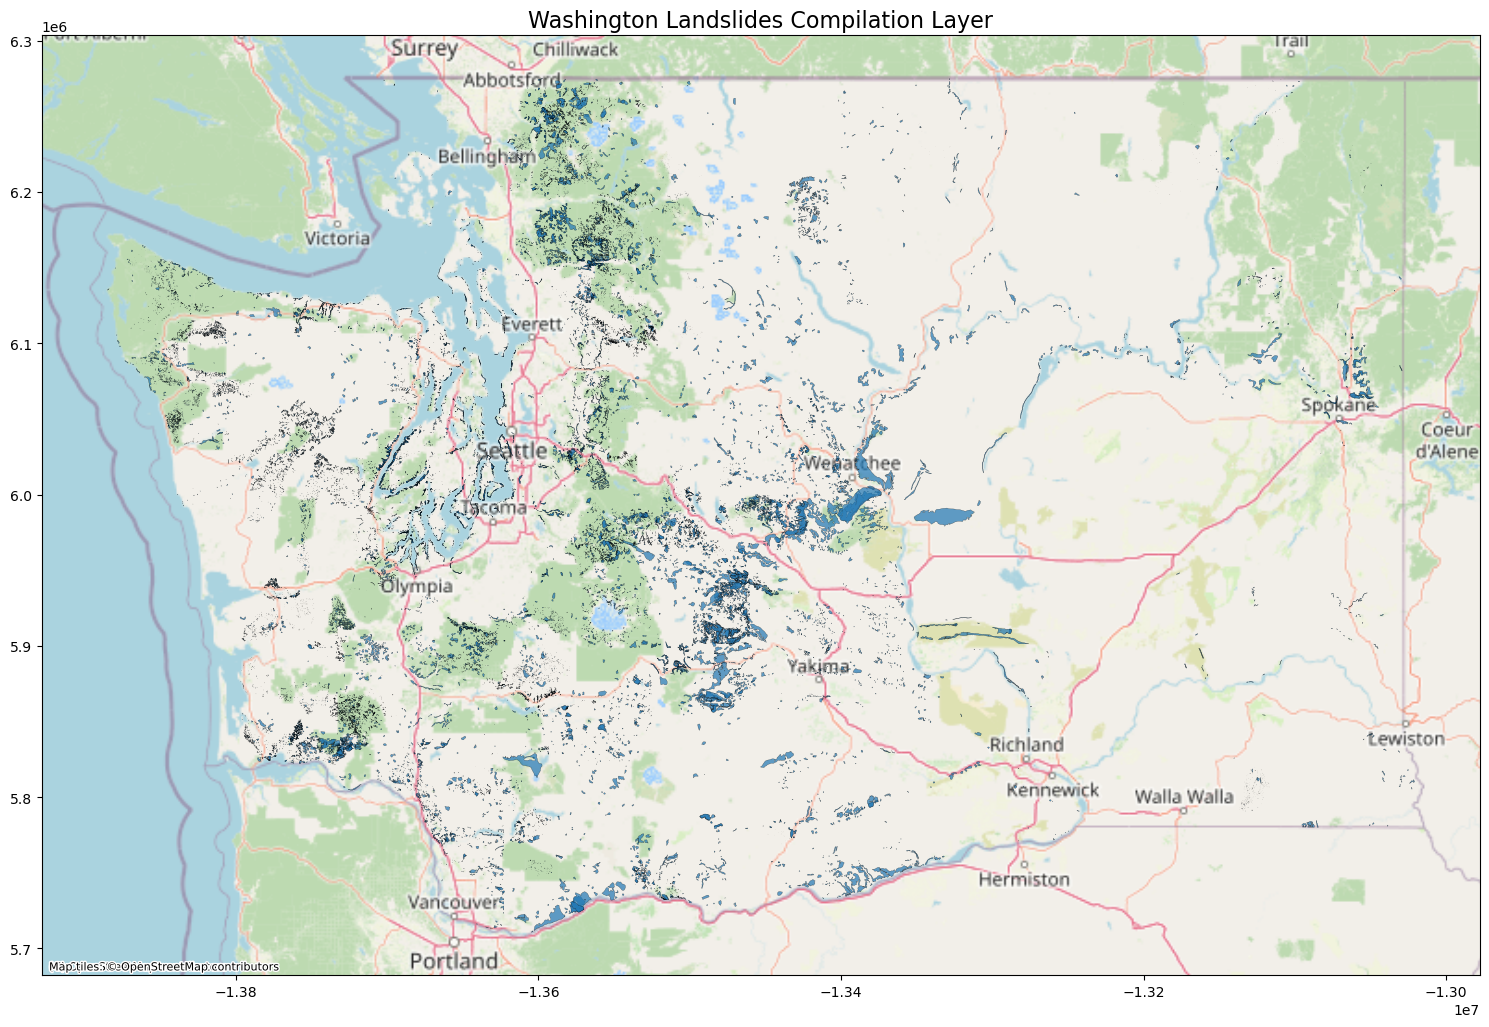

In [10]:
import matplotlib.pyplot as plt
import contextily as ctx

gdf_3857 = compilation.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(15, 15))
gdf_3857.plot(ax=ax, edgecolor="k", linewidth=0.2, alpha=0.7)

# When the axis data is already in EPSG:3857, you can omit the crs argument:
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.title('Washington Landslides Compilation Layer', fontsize=16)
ctx.add_attribution(ax, "Map tiles: © OpenStreetMap contributors")
plt.tight_layout()
plt.show()


In [22]:
print("Columns in compilation:")
for col in compilation.columns:
    print(f"  - {col}")

Columns in compilation:
  - LANDSLIDE_ID
  - LANDSLIDE_TYPE
  - DSLS_MORPHOLOGY
  - LANDSLIDE_NAME
  - GRADIENT_DEGREES
  - GRADIENT_METHOD
  - SLOPE_MORPHOLOGY
  - ASPECT
  - GEOLOGIC_UNIT_LABEL
  - STRUCTURE_ASSOCIATION
  - LANDSLIDE_TRIGGER_EVENT
  - LANDSLIDE_CERTAINTY
  - LANDSLIDE_DATE
  - LANDSLIDE_LIMIT_DATE
  - FIELD_CHECK
  - INFRASTRUCTURE_DAMAGE
  - LAND_USE
  - LOCATION_CONFIDENCE
  - DATA_CONFIDENCE
  - COMMENTS
  - FEATURE_SOURCE
  - SOURCE_INFORMATION
  - SOURCE_DB_FEATURE_ID
  - SOURCE_URL
  - DISPLAY_ON_PORTAL
  - CHANGE_TYPE
  - CHANGE_DATE
  - CHANGE_DESCRIPTION
  - Shape_Length
  - Shape_Area
  - geometry


In [23]:
# Compare column names and values between deposits and compilation layers
print("Deposits columns:")
for col in deposits.columns:
    print(f"  - {col}")

print("\nCompilation columns:")
for col in compilation.columns:
    print(f"  - {col}")

# Check for potential matching columns
print("\nPotential matching columns:")
deposits_cols = set(deposits.columns)
compilation_cols = set(compilation.columns)

# Find common columns
common_cols = deposits_cols.intersection(compilation_cols)
print("Common columns:", list(common_cols))

# Check unique values in confidence-related columns
print("\nUnique values in deposits CONFIDENCE:")
print(deposits['CONFIDENCE'].value_counts())

if 'LOCATION_CONFIDENCE' in compilation.columns:
    print("\nUnique values in compilation LOCATION_CONFIDENCE:")
    print(compilation['LOCATION_CONFIDENCE'].value_counts())

if 'DATA_CONFIDENCE' in compilation.columns:
    print("\nUnique values in compilation DATA_CONFIDENCE:")
    print(compilation['DATA_CONFIDENCE'].value_counts())
    

Deposits columns:
  - LANDSLIDE_ID
  - MATERIAL
  - MOVEMENT
  - MOVE_CODE
  - CONFIDENCE
  - RELATIVE_AGE
  - YEAR_MOVE
  - FIELD_VERIFIED
  - SLOPE_DEG
  - HS_HEIGHT_FT
  - FAIL_DEPTH_FT
  - MVMT_AZIMUTH_DEG
  - VOLUME_FT3
  - AVG_SCARP_DIST_FT
  - LS_NAME
  - COMMENTS
  - DISPLAY_ON_PORTAL
  - CHANGE_TYPE
  - CHANGE_DATE
  - CHANGE_DESCRIPTION
  - Shape_Length
  - Shape_Area
  - geometry

Compilation columns:
  - LANDSLIDE_ID
  - LANDSLIDE_TYPE
  - DSLS_MORPHOLOGY
  - LANDSLIDE_NAME
  - GRADIENT_DEGREES
  - GRADIENT_METHOD
  - SLOPE_MORPHOLOGY
  - ASPECT
  - GEOLOGIC_UNIT_LABEL
  - STRUCTURE_ASSOCIATION
  - LANDSLIDE_TRIGGER_EVENT
  - LANDSLIDE_CERTAINTY
  - LANDSLIDE_DATE
  - LANDSLIDE_LIMIT_DATE
  - FIELD_CHECK
  - INFRASTRUCTURE_DAMAGE
  - LAND_USE
  - LOCATION_CONFIDENCE
  - DATA_CONFIDENCE
  - COMMENTS
  - FEATURE_SOURCE
  - SOURCE_INFORMATION
  - SOURCE_DB_FEATURE_ID
  - SOURCE_URL
  - DISPLAY_ON_PORTAL
  - CHANGE_TYPE
  - CHANGE_DATE
  - CHANGE_DESCRIPTION
  - Shape_Length
  

In [26]:
# Check current DATA_CONFIDENCE values in compilation
print("Current DATA_CONFIDENCE values in compilation:")
print(compilation['DATA_CONFIDENCE'].value_counts())

# Create a mapping for standardizing confidence levels
confidence_mapping = {
    'Moderate-High': 'Moderate',
    'Low': 'Low', 
    'Moderate': 'Moderate',
    'Low-Moderate': 'Moderate',
    'High': 'High'
}

# Apply the mapping to create a new standardized confidence column
compilation['CONFIDENCE'] = compilation['DATA_CONFIDENCE'].map(confidence_mapping)

# Check the results
print("\nStandardized confidence distribution:")
print(compilation['CONFIDENCE'].value_counts())

Current DATA_CONFIDENCE values in compilation:
DATA_CONFIDENCE
Moderate-High    39858
Low               8469
Moderate          5547
Low-Moderate      4225
High               107
Name: count, dtype: int64

Standardized confidence distribution:
CONFIDENCE
Moderate    49630
Low          8469
High          107
Name: count, dtype: int64


In [30]:
# Inspect SLOPE_MORPHOLOGY in compilation layer
print("SLOPE_MORPHOLOGY values in compilation:")
print(compilation['SLOPE_MORPHOLOGY'].value_counts())


SLOPE_MORPHOLOGY values in compilation:
SLOPE_MORPHOLOGY
Unknown                24787
Planar                  7271
Concave, convergent     7240
Concave-planar          6439
Irregular               1569
Planar-convex            602
Convex, divergent        365
Name: count, dtype: int64


## Create References for Compilation and Deposits Layer

In [40]:
# Inspect unique values in SOURCE_INFORMATION column from compilation layer
print("Unique SOURCE_INFORMATION values in compilation:")
unique_sources = compilation['SOURCE_INFORMATION'].value_counts()
print(unique_sources)

print(f"\nTotal number of unique sources: {len(unique_sources)}")

# Look at some sample source information entries
print("\nSample SOURCE_INFORMATION entries:")
sample_sources = compilation['SOURCE_INFORMATION'].dropna().head(10)
for i, source in enumerate(sample_sources, 1):
    print(f"{i}. {source}")

Unique SOURCE_INFORMATION values in compilation:
SOURCE_INFORMATION
Washington State Department of Natural Resources, unpublished GIS data                                                                                                                                                                                                                                     25625
Sarikhan, I. Y.; Stanton, K. D.; Contreras, T. A.; Polenz, Michael; Powell, Jack; Walsh, T. J.; Logan, R. L., 2008, Landslide reconnaissance following the storm event of December 1-3, 2007, in western Washington: Washington Division of Geology and Earth Resources Open File Report 2008-5, 16 p.      1960
Sarikhan, I. Y.; Walsh, T. J., 2007, Landslide hazard zonation project--Mass wasting assessment--Mason watershed, Mason County, Washington: Washington Department of Natural Resources, Forest Practices Division, 25 p., 2 plates, scale 1:24,000.                                                         1801
Sarikhan, Isabell

In [57]:
# Create a new column 'Reference' in compilation and copy SOURCE_INFORMATION values to it
compilation['Reference'] = compilation['SOURCE_INFORMATION']

# Verify the new column was created
print("New 'Reference' column created successfully")
print("Sample Reference values:")
print(compilation['Reference'].head())

New 'Reference' column created successfully
Sample Reference values:
0    Hammond, Paul E., 2010, Geologic map of the Cl...
1    Hammond, Paul E., 2009, Geologic map of the Me...
2    Hammond, Paul E., 2009, Geologic map of the Me...
3    Hammond, Paul E., 2010, Geologic map of the Cl...
4    Campbell, N. P., 1976, Preliminary geologic ma...
Name: Reference, dtype: object


In [58]:
deposits['Reference'] = 'WGS'

## Add Dataset Link and Origin

In [59]:
# Add ORIGIN column to both datasets
compilation['ORIGIN'] = 'WASHINGTON'
deposits['ORIGIN'] = 'WASHINGTON'

print("Added ORIGIN column to both datasets")
print("Compilation ORIGIN values:", compilation['ORIGIN'].unique())
print("Deposits ORIGIN values:", deposits['ORIGIN'].unique())

Added ORIGIN column to both datasets
Compilation ORIGIN values: ['WASHINGTON']
Deposits ORIGIN values: ['WASHINGTON']


In [60]:
# Add DATASET_LINK column to deposits layer only
deposits['DATASET_LINK'] = 'https://dnr.wa.gov/washington-geological-survey/geologic-hazards-and-environment/landslides'

print("Added DATASET_LINK column to deposits layer")
print("Sample DATASET_LINK values:", deposits['DATASET_LINK'].head())

Added DATASET_LINK column to deposits layer
Sample DATASET_LINK values: 0    https://dnr.wa.gov/washington-geological-surve...
1    https://dnr.wa.gov/washington-geological-surve...
2    https://dnr.wa.gov/washington-geological-surve...
3    https://dnr.wa.gov/washington-geological-surve...
4    https://dnr.wa.gov/washington-geological-surve...
Name: DATASET_LINK, dtype: object


# Combine Landslide Compilation and Deposits layer

In [61]:
# Combine the compilation and deposits layers, giving priority to deposits layer
combined_landslides = gpd.GeoDataFrame(pd.concat([deposits, compilation], ignore_index=True), crs=deposits.crs)

print("Combined dataset shape:", combined_landslides.shape)
print("Deposits shape:", deposits.shape)
print("Compilation shape:", compilation.shape)

Combined dataset shape: (73471, 50)
Deposits shape: (15060, 27)
Compilation shape: (58411, 36)


In [62]:
print("Columns in combined dataset:")
for col in combined_landslides.columns:
    print(f"  - {col}")

Columns in combined dataset:
  - LANDSLIDE_ID
  - MATERIAL
  - MOVEMENT
  - MOVE_CODE
  - CONFIDENCE
  - RELATIVE_AGE
  - YEAR_MOVE
  - FIELD_VERIFIED
  - SLOPE_DEG
  - HS_HEIGHT_FT
  - FAIL_DEPTH_FT
  - MVMT_AZIMUTH_DEG
  - VOLUME_FT3
  - AVG_SCARP_DIST_FT
  - LS_NAME
  - COMMENTS
  - DISPLAY_ON_PORTAL
  - CHANGE_TYPE
  - CHANGE_DATE
  - CHANGE_DESCRIPTION
  - Shape_Length
  - Shape_Area
  - geometry
  - References
  - ORIGIN
  - DATASET_LINK
  - Reference
  - LANDSLIDE_TYPE
  - DSLS_MORPHOLOGY
  - LANDSLIDE_NAME
  - GRADIENT_DEGREES
  - GRADIENT_METHOD
  - SLOPE_MORPHOLOGY
  - ASPECT
  - GEOLOGIC_UNIT_LABEL
  - STRUCTURE_ASSOCIATION
  - LANDSLIDE_TRIGGER_EVENT
  - LANDSLIDE_CERTAINTY
  - LANDSLIDE_DATE
  - LANDSLIDE_LIMIT_DATE
  - FIELD_CHECK
  - INFRASTRUCTURE_DAMAGE
  - LAND_USE
  - LOCATION_CONFIDENCE
  - DATA_CONFIDENCE
  - FEATURE_SOURCE
  - SOURCE_INFORMATION
  - SOURCE_DB_FEATURE_ID
  - SOURCE_URL
  - CONFIDENCE_STANDARDIZED


# New DataFrame Creation

In [63]:
columns_to_keep = [
    'LANDSLIDE_ID', 
    'MATERIAL', 
    'MOVEMENT', 
    'MOVE_CODE',
    'CONFIDENCE',
    'RELATIVE_AGE', 
    'YEAR_MOVE',
    'SLOPE_DEG', 
    'HS_HEIGHT_FT', 
    'FAIL_DEPTH_FT',
    'MVMT_AZIMUTH_DEG',
    'VOLUME_FT3',
    'AVG_SCARP_DIST_FT', 
    'LS_NAME',
    'Shape_Length',
    'Shape_Area',
    'Reference',
    'ORIGIN',
    'DATASET_LINK',
    'geometry'
]

# Create a new GeoDataFrame with only the selected columns
washington_landslides = gpd.GeoDataFrame(combined_landslides[columns_to_keep], geometry='geometry', crs=deposits.crs)

## Inspect the new DataFrame

In [64]:
print("New GeoDataFrame shape:", washington_landslides.shape)
print("\nColumn names:")
for col in washington_landslides.columns:
    print(f"  - {col}")

washington_landslides.head()

New GeoDataFrame shape: (73471, 20)

Column names:
  - LANDSLIDE_ID
  - MATERIAL
  - MOVEMENT
  - MOVE_CODE
  - CONFIDENCE
  - RELATIVE_AGE
  - YEAR_MOVE
  - SLOPE_DEG
  - HS_HEIGHT_FT
  - FAIL_DEPTH_FT
  - MVMT_AZIMUTH_DEG
  - VOLUME_FT3
  - AVG_SCARP_DIST_FT
  - LS_NAME
  - Shape_Length
  - Shape_Area
  - Reference
  - ORIGIN
  - DATASET_LINK
  - geometry


LANDSLIDE_ID         MATERIAL MOVEMENT MOVE_CODE        CONFIDENCE  \
0         18414  Earth or debris     Flow       EFL        Low (1-10)   
1         20629  Earth or debris  Complex  ES-R+EFL        Low (1-10)   
2         20630  Earth or debris  Complex  ES-R+EFL        Low (1-10)   
3         20661  Earth or debris   Topple        ET  Moderate (11-29)   
4         20594  Earth or debris   Topple        ET  Moderate (11-29)   

                RELATIVE_AGE YEAR_MOVE  SLOPE_DEG  HS_HEIGHT_FT  \
0  Pre-historic (>150 years)       NaN       11.0           3.0   
1  Pre-historic (>150 years)       NaN       39.0          11.0   
2  Pre-historic (>150 years)       NaN       37.0          11.0   
3  Pre-historic (>150 years)       NaN       61.0          24.0   
4  Pre-historic (>150 years)       NaN       33.0          29.0   

   FAIL_DEPTH_FT  MVMT_AZIMUTH_DEG    VOLUME_FT3  AVG_SCARP_DIST_FT LS_NAME  \
0            3.0             225.0   1322.894339                NaN     NaN   
1            9.0             180.0   4039.516598                NaN     NaN   
2            9.0             180.0   4563.138478                NaN     NaN   
3           12.0             225.0   6320.755277                NaN     NaN   
4           24.0             135.0  13016.550042                NaN     NaN   

   Shape_Length  Shape_Area Reference      ORIGIN  \
0     82.334854  440.966914       WGS  WASHINGTON   
1     77.534531  441.695598       WGS  WASHINGTON   
2     81.931760  483.669276       WGS  WASHINGTON   
3     85.493104  509.669212       WGS  WASHINGTON   
4     91.365031  528.125198       WGS  WASHINGTON   

                                        DATASET_LINK  \
0  https://dnr.wa.gov/washington-geological-surve...   
1  https://dnr.wa.gov/washington-geological-surve...   
2  https://dnr.wa.gov/washington-geological-surve...   
3  https://dnr.wa.gov/washington-geological-surve...   
4  https://dnr.wa.gov/washington-geological-surve...   

                                            geometry  
0  MULTIPOLYGON (((1043516.638 614643.978, 104351...  
1                                 MULTIPOLYGON EMPTY  
2                                 MULTIPOLYGON EMPTY  
3  MULTIPOLYGON (((1032543.812 660981.578, 103254...  
4                                 MULTIPOLYGON EMPTY

In [65]:
washington_column_mapping = {
    'YEAR_MOVE': 'YEAR',
    'SLOPE_DEG': 'SLOPE',
    'HS_HEIGHT_FT': 'HS_HEIGHT',
    'FAIL_DEPTH_FT': 'FAIL_DEPTH',
    'VOLUME_FT3': 'VOLUME',
    'LS_NAME': 'NAME'
}

In [66]:
washington_landslides.rename(columns=washington_column_mapping, inplace=True)

In [67]:
washington_landslides.dtypes

LANDSLIDE_ID            int64
MATERIAL               object
MOVEMENT               object
MOVE_CODE              object
CONFIDENCE             object
RELATIVE_AGE           object
YEAR                   object
SLOPE                 float64
HS_HEIGHT             float64
FAIL_DEPTH            float64
MVMT_AZIMUTH_DEG      float64
VOLUME                float64
AVG_SCARP_DIST_FT     float64
NAME                   object
Shape_Length          float64
Shape_Area            float64
Reference              object
ORIGIN                 object
DATASET_LINK           object
geometry             geometry
dtype: object

# Save the DataFrame

In [68]:
washington_landslides.to_file("./ProcessedDataSets/washington_landslides_processed.geojson", driver="GeoJSON")

In [11]:
loaded_landslides = gpd.read_file("./ProcessedDataSets/washington_landslides_processed.geojson")
print("Loaded GeoDataFrame shape:", loaded_landslides.shape)
loaded_landslides.head()

Loaded GeoDataFrame shape: (15060, 17)


LANDSLIDE_ID         MATERIAL MOVEMENT MOVE_CODE        CONFIDENCE  \
0         18414  Earth or debris     Flow       EFL        Low (1-10)   
1         20629  Earth or debris  Complex  ES-R+EFL        Low (1-10)   
2         20630  Earth or debris  Complex  ES-R+EFL        Low (1-10)   
3         20661  Earth or debris   Topple        ET  Moderate (11-29)   
4         20594  Earth or debris   Topple        ET  Moderate (11-29)   

                RELATIVE_AGE  YEAR  SLOPE  HS_HEIGHT  FAIL_DEPTH  \
0  Pre-historic (>150 years)  None     11        3.0         3.0   
1  Pre-historic (>150 years)  None     39       11.0         9.0   
2  Pre-historic (>150 years)  None     37       11.0         9.0   
3  Pre-historic (>150 years)  None     61       24.0        12.0   
4  Pre-historic (>150 years)  None     33       29.0        24.0   

   MVMT_AZIMUTH_DEG        VOLUME  AVG_SCARP_DIST_FT  NAME  Shape_Length  \
0             225.0   1322.894339                NaN  None     82.334854   
1             180.0   4039.516598                NaN  None     77.534531   
2             180.0   4563.138478                NaN  None     81.931760   
3             225.0   6320.755277                NaN  None     85.493104   
4             135.0  13016.550042                NaN  None     91.365031   

   Shape_Area                                           geometry  
0  440.966914  MULTIPOLYGON (((1043516.638 614643.978, 104351...  
1  441.695598                               MULTIPOLYGON (EMPTY)  
2  483.669276                               MULTIPOLYGON (EMPTY)  
3  509.669212  MULTIPOLYGON (((1032543.812 660981.578, 103254...  
4  528.125198                               MULTIPOLYGON (EMPTY)

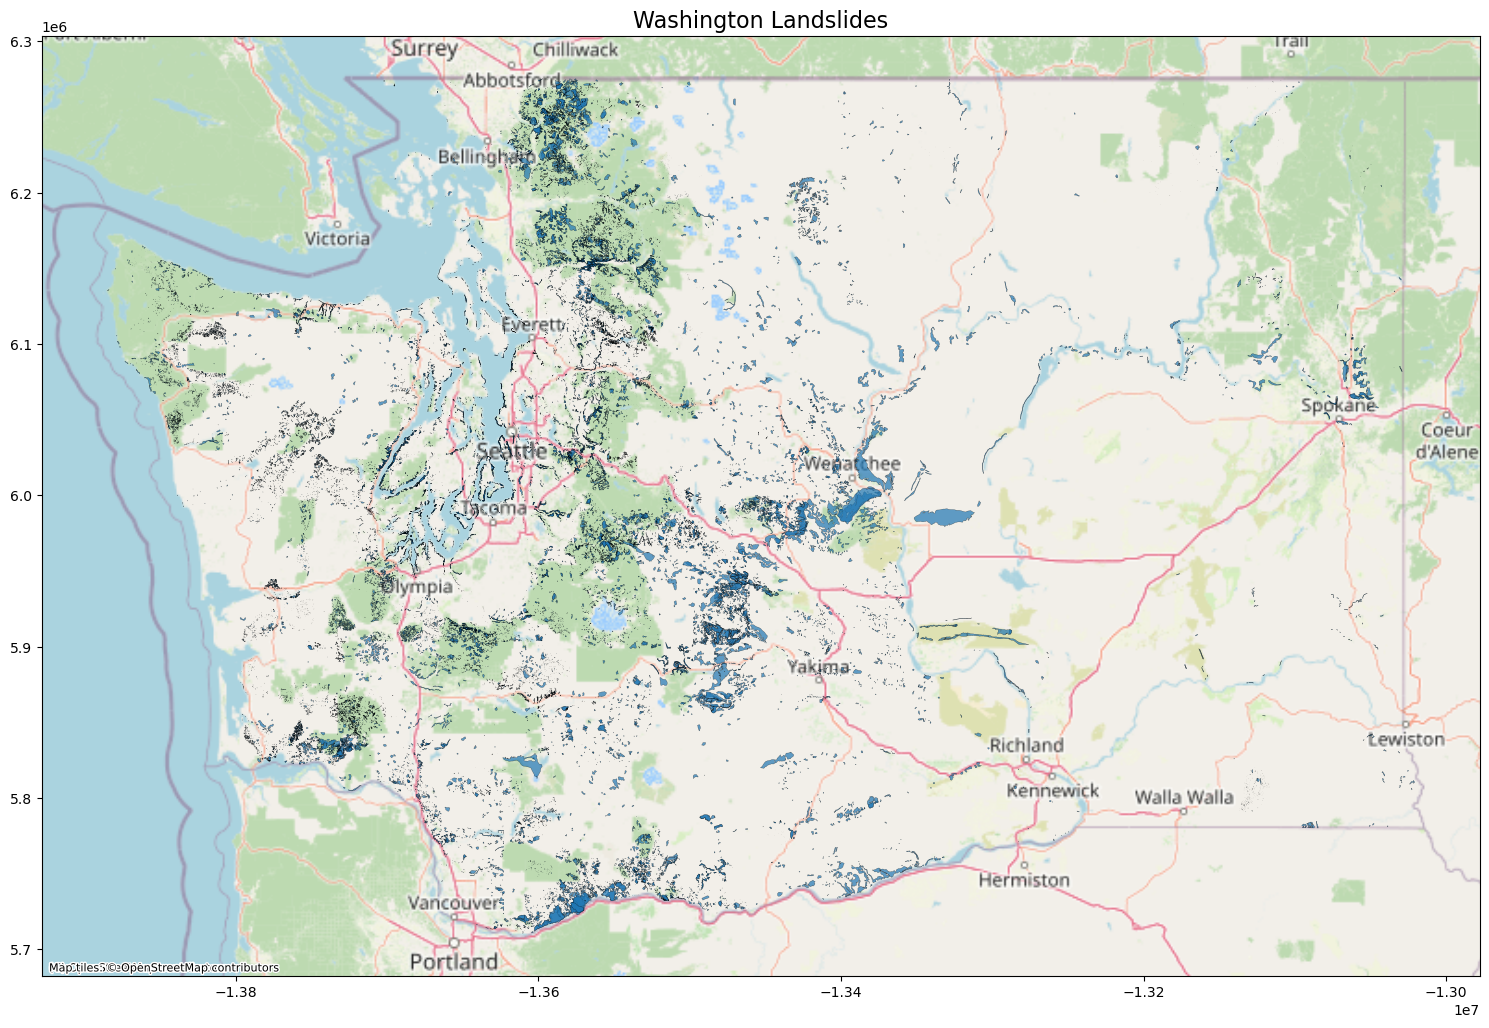

In [56]:
import matplotlib.pyplot as plt
import contextily as ctx

gdf_3857 = washington_landslides.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(15, 15))
gdf_3857.plot(ax=ax, edgecolor="k", linewidth=0.2, alpha=0.7)

# When the axis data is already in EPSG:3857, you can omit the crs argument:
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.title('Washington Landslides', fontsize=16)
ctx.add_attribution(ax, "Map tiles: © OpenStreetMap contributors")
plt.tight_layout()
plt.show()
